In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [11]:
fol = "ExpMOEA_D_Penalty/"

path = fol + "2023_08_20_17:30:10/result_1.json"


with open('../EvolutionaryFramework/results/MOEA_D/' + path) as user_file:
  parsed_json = json.load(user_file)
  
# print(json.dumps(parsed_json, indent = 4, sort_keys=True))

In [12]:
data = []
metaParameters = []
for elem in parsed_json:
    if elem == "metaParameters":
        metaDictionary = {
            'algorithmName': parsed_json[elem]["algorithmName"],
            'populationSize': parsed_json[elem]["populationSize"],
            'numberOfBars': parsed_json[elem]["numberOfBars"],
            'maxNumberOfNotes': parsed_json[elem]["maxNumberOfNotes"],
            'representationType': parsed_json[elem]["representationType"],
            'melodyKeyValue': parsed_json[elem]["melodyKeyValue"],
            'melodyKeyType': parsed_json[elem]["melodyKeyType"],
            'crossoverProbability': parsed_json[elem]["crossoverProbability"],
            'mutationProbability': parsed_json[elem]["mutationProbability"],
            'selectionType': parsed_json[elem]["selectionType"],
            'matingPoolSelectionType': parsed_json[elem]["matingPoolSelectionType"],
            'numberOfGenerations': parsed_json[elem]["numberOfGenerations"],
            'criteria': parsed_json[elem]["criteria"],
        }
        for key, value in parsed_json[elem]["weightsValues"].items():
            metaDictionary["weightsValues_" + key] = value
        for key, value in parsed_json[elem]["crossoverType"].items():
            metaDictionary["crossoverType_" + key] = value
        for key, value in parsed_json[elem]["mutationType"].items():
            metaDictionary["mutationType_" + key] = value
metaParameters.append(metaDictionary)

metaParameters_df = pd.DataFrame(metaParameters)   


for elem in parsed_json:
        if elem == "experiment":
            for generation in parsed_json[elem]:
                for individual in parsed_json[elem][generation]:
                    dictionary = {}
                    dictionary = {
                        'generation': generation,
                        'melody': individual['melody'],
                        'penalty': individual['penalty']
                    }
                    for criterion in metaParameters_df['criteria'].values[0]:
                        dictionary[criterion] = individual['fitness'][criterion]
                    data.append(dictionary)
data_df = pd.DataFrame(data)

In [13]:
# ( fitness - min ) / ( max - min )

weightsMin = 0.0
weightsMax = 0.1

penaltyMin = 0.0
penaltyMax = 0.9


criteria = metaParameters_df['criteria'].values[0]


for criterion in criteria:
    data_df[criterion] = ( data_df[criterion] - data_df['penalty'] - weightsMin ) / (weightsMax - weightsMin)
data_df['penalty'] = ( data_df['penalty'] - penaltyMin ) / (penaltyMax - penaltyMin)

In [14]:
list_of_generations = []

for gen in data_df["generation"].unique():
    front_data = data_df[data_df["generation"] == gen]
    front_elements = []

    penaltyBoolean = False
    front_penalty = []
    for penalty in front_data["penalty"]:
        front_penalty.append(penalty)

    for criterion in metaParameters_df['criteria'].values[0]:
        front_temp = []
        for i, individual in enumerate(front_data[criterion]):
            front_temp.append(individual)
        front_elements.append(front_temp)
    front_elements.append(front_penalty)
    list_of_generations.append(front_elements)

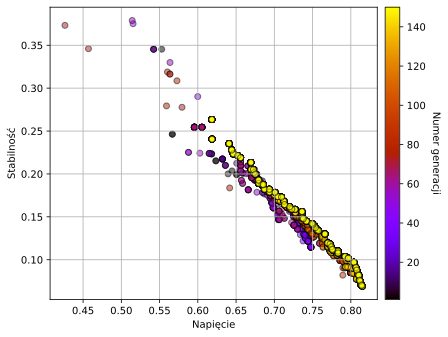

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots()

# Assuming `metaParameters_df['criteria'].values[0]` contains criterion names
criteria = metaParameters_df['criteria'].values[0]
ax.set_xlabel("Napięcie")
ax.set_ylabel("Stabilność")

ax.grid()

# Create a continuous colormap
cmap = plt.get_cmap('gnuplot')

# Extracting the generation numbers from the list_of_generations
generation_numbers = [i+1 for i, _ in enumerate(list_of_generations)]

# Normalize the generation numbers to [0, 1] for color mapping
norm = mcolors.Normalize(vmin=min(generation_numbers), vmax=max(generation_numbers))

# Create a scalar mappable for color mapping
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for mapping

for i, (x, y, z) in enumerate(list_of_generations):
    color = sm.to_rgba(i)  # Get the color from the colormap
    ax.scatter(x, y, label=f"generation {i}", alpha=0.5, color=color, edgecolors='black')

# Automatically adjust Y-axis limits
plt.autoscale(enable=True, axis='y')

# Add the colorscale reference on the right
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Numer generacji', rotation=-90, labelpad=15)  # Adjust labelpad as needed

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


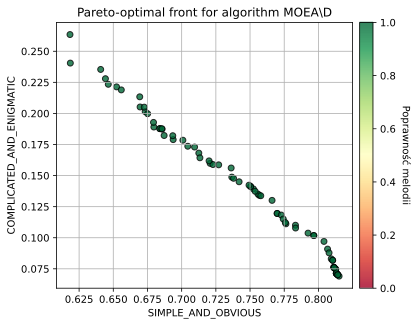

In [16]:
fig, ax = plt.subplots()
ax.set_title("Pareto-optimal front for algorithm MOEA\D")
for i, criterion in enumerate(metaParameters_df['criteria'].values[0]):
    if i == 0:
        ax.set_xlabel(criterion)
    else:
        ax.set_ylabel(criterion)
ax.grid()

sc = ax.scatter(list_of_generations[-1][0], list_of_generations[-1][1], c=list_of_generations[-1][2], edgecolors='black', cmap='RdYlGn', alpha=0.8, vmin=0, vmax=1)

plt.autoscale(enable=True, axis='y')

# Add the colorscale reference on the right
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label('Poprawność melodii',  rotation=-90, labelpad=15)


plt.show()

